In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
import geopandas as gpd

# Load shapefile
world = gpd.read_file('/kaggle/input/india-shape/ne_10m_admin_0_countries.shp')
india = world[world['ADMIN'] == 'India']

# Check geometry
print(india.geometry)


8    MULTIPOLYGON (((77.80035 35.49541, 77.81533 35...
Name: geometry, dtype: geometry


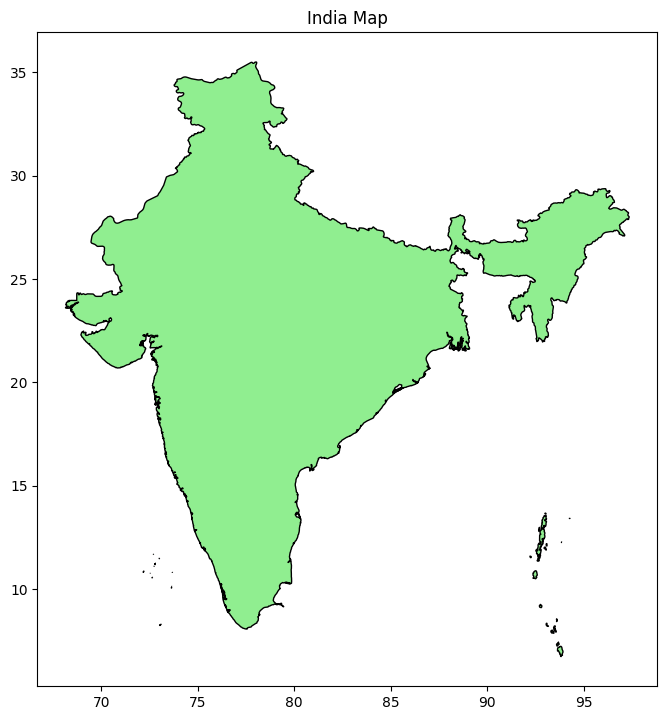

In [15]:
import matplotlib.pyplot as plt

india.plot(figsize=(8, 10), edgecolor='black', color='lightgreen')
plt.title("India Map")
plt.show()


In [19]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load your dataset
df = pd.read_csv('/kaggle/input/flood-all1/flood_risk_dataset_india.csv')  # your raw dataset

# Load Natural Earth shapefile
world = gpd.read_file('/kaggle/input/india-shape/ne_10m_admin_0_countries.shp')

# Extract India polygon
india = world[world['ADMIN'] == 'India']

# Shrink India polygon slightly to remove border points (buffer with negative value)
india_shrunk = india.geometry.buffer(-0.05).unary_union  # ~0.05 degrees (~5km)

# Convert your dataset to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Keep only points strictly inside shrunk India polygon
gdf_cleaned = gdf[gdf.geometry.within(india_shrunk)]

# Drop geometry column if not needed
gdf_cleaned = gdf_cleaned.drop(columns='geometry')

# Save the strictly cleaned dataset
gdf_cleaned.to_csv('data_india_strict_2.csv', index=False)

print("Final strictly cleaned dataset saved. Remaining rows:", len(gdf_cleaned))


/tmp/ipykernel_36/685629554.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  india_shrunk = india.geometry.buffer(-0.05).unary_union  # ~0.05 degrees (~5km)


Final strictly cleaned dataset saved. Remaining rows: 3209


In [20]:
import pandas as pd
import numpy as np

# Load your cleaned dataset
df = pd.read_csv('/kaggle/working/data_india_strict_2.csv')

# Target number of rows
target_rows = 50000
current_rows = len(df)
n_new = target_rows - current_rows  # number of synthetic rows to generate

# Sample random rows with replacement
sampled = df.sample(n=n_new, replace=True)

# Add small Gaussian noise (~1-2%) to numeric columns
numeric_cols = ['Rainfall (mm)','Temperature (°C)','Humidity (%)',
                'River Discharge (m³/s)','Water Level (m)',
                'Elevation (m)','Population Density','Infrastructure',
                'Historical Floods']

for col in numeric_cols:
    sampled[col] = sampled[col] * (1 + np.random.normal(0, 0.01, size=n_new))

# Combine original dataset with synthetic rows
df_augmented = pd.concat([df, sampled]).reset_index(drop=True)

print("Original size:", len(df))
print("Augmented size:", len(df_augmented))

# Save the final augmented dataset
df_augmented.to_csv('data_india_50000.csv', index=False)

Original size: 3209
Augmented size: 50000


In [22]:
import pandas as pd
import numpy as np

# Load cleaned dataset
df = pd.read_csv('/kaggle/working/data_india_strict_2.csv')

# Target rows
target_rows = 50000
current_rows = len(df)
n_new = target_rows - current_rows

# Sample rows with replacement
sampled = df.sample(n=n_new, replace=True)

# Numeric columns (add small noise)
numeric_cols = ['Rainfall (mm)','Temperature (°C)','Humidity (%)',
                'River Discharge (m³/s)','Water Level (m)',
                'Elevation (m)','Population Density']

for col in numeric_cols:
    sampled[col] = sampled[col] * (1 + np.random.normal(0, 0.01, size=n_new))

# Binary columns (0 or 1) – keep them as integers
binary_cols = ['Infrastructure', 'Historical Floods', 'Flood Occurred']

for col in binary_cols:
    sampled[col] = sampled[col].sample(n=n_new, replace=True).values  # resample 0/1

# Combine with original dataset
df_augmented = pd.concat([df, sampled]).reset_index(drop=True)

print("Original size:", len(df))
print("Augmented size:", len(df_augmented))

# Save final augmented dataset
df_augmented.to_csv('data_india_50000_fixed_1.csv', index=False)


Original size: 3209
Augmented size: 50000


First 5 rows of shapefile:
   ID_0  ISO NAME_0  ID_1               NAME_1  ID_2  \
0   105  IND  India     1  Andaman and Nicobar     1   
1   105  IND  India     1  Andaman and Nicobar     2   
2   105  IND  India     1  Andaman and Nicobar     3   
3   105  IND  India     2       Andhra Pradesh     4   
4   105  IND  India     2       Andhra Pradesh     4   

                     NAME_2  ID_3        NAME_3  CCN_3 CCA_3 TYPE_3 ENGTYPE_3  \
0           Nicobar Islands     1  n.a. ( 2304)      0  None  Taluk     Taluk   
1  North and Middle Andaman     2  n.a. ( 2178)      0  None  Taluk     Taluk   
2             South Andaman     3  n.a. ( 2178)      0  None  Taluk     Taluk   
3                 Anantapur     4     Anantapur      0  None  Taluk     Taluk   
4                 Anantapur     5   Dharmavaram      0  None  Taluk     Taluk   

  NL_NAME_3 VARNAME_3                                           geometry  
0      None      None  MULTIPOLYGON (((92.78778 9.24417, 92.78889 9.2...  

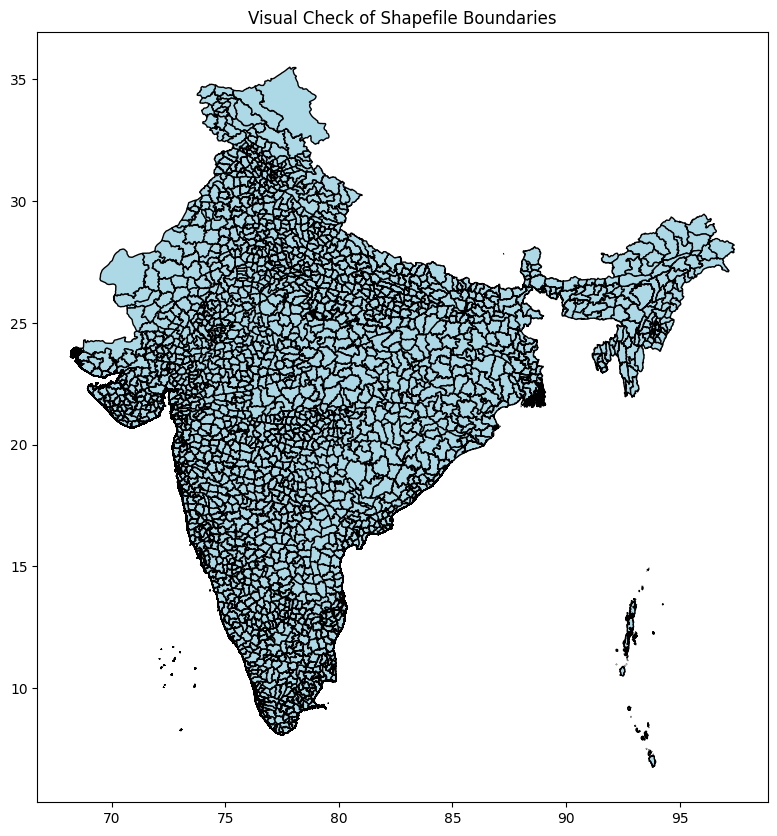


Unique States/Level 1 names: ['Andaman and Nicobar' 'Andhra Pradesh' 'Arunachal Pradesh' 'Assam'
 'Bihar' 'Chandigarh' 'Chhattisgarh' 'Dadra and Nagar Haveli'
 'Daman and Diu' 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh'
 'Jammu and Kashmir' 'Jharkhand' 'Karnataka' 'Kerala' 'Lakshadweep'
 'Madhya Pradesh' 'Maharashtra' 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland'
 'NCT of Delhi' 'Odisha' 'Puducherry' 'Punjab' 'Rajasthan' 'Sikkim'
 'Tamil Nadu' 'Telangana' 'Tripura' 'Uttar Pradesh' 'Uttarakhand'
 'West Bengal']

Unique Districts/Level 2 names: ['Nicobar Islands' 'North and Middle Andaman' 'South Andaman' 'Anantapur'
 'Chittoor' 'East Godavari' 'Guntur' 'Krishna' 'Kurnool' 'Nellore'
 'Prakasam' 'Srikakulam' 'Visakhapatnam' 'Vizianagaram' 'West Godavari'
 'Y.S.R.' 'Anjaw' 'Changlang' 'Dibang Valley' 'East Kameng' 'East Siang'
 'Kurung Kumey' 'Lohit' 'Longding' 'Lower Dibang Valley' 'Lower Subansiri'
 'Namsai' 'Papum Pare' 'Tawang' 'Tirap' 'Upper Siang' 'Upper Subansiri'
 'West Kameng' 'Wes

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your shapefile
# Replace with the path to your shapefile
shapefile_path = "/kaggle/input/india-map-state-district-boundaries/India-map/IND_adm3.shp"
gdf = gpd.read_file(shapefile_path)

# Check first few rows
print("First 5 rows of shapefile:")
print(gdf.head())

# Check column names
print("\nColumns in shapefile:")
print(gdf.columns)

# Check the CRS (Coordinate Reference System)
print("\nCRS of shapefile:")
print(gdf.crs)

# Check basic info and geometry type
print("\nGeoDataFrame info:")
print(gdf.info())
print("\nGeometry types:")
print(gdf.geom_type.value_counts())

# Plot the shapefile to visually verify
gdf.plot(figsize=(10,10), edgecolor='black', color='lightblue')
plt.title("Visual Check of Shapefile Boundaries")
plt.show()

# Optional: print unique values in key columns
if 'NAME_1' in gdf.columns:
    print("\nUnique States/Level 1 names:", gdf['NAME_1'].unique())
if 'NAME_2' in gdf.columns:
    print("\nUnique Districts/Level 2 names:", gdf['NAME_2'].unique())


In [27]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# --------------------------
# 1. Load your dataset
# --------------------------
df = pd.read_csv("/kaggle/working/data_india_50000_fixed_1.csv")

# Check columns
print(df.head())

# --------------------------
# 2. Convert your dataset to a GeoDataFrame
# --------------------------
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# --------------------------
# 3. Load the shapefile (India States/Districts)
# --------------------------
shapefile_path = "/kaggle/input/india-map-state-district-boundaries/India-map/IND_adm3.shp"
gdf_shapes = gpd.read_file(shapefile_path)

# --------------------------
# 4. Drop any conflicting columns to avoid sjoin error
# --------------------------
gdf_points = gdf_points.loc[:, ~gdf_points.columns.isin(['index_left', 'index_right'])]
gdf_shapes = gdf_shapes.loc[:, ~gdf_shapes.columns.isin(['index_left', 'index_right'])]

# --------------------------
# 5. Spatial join to assign State and District in one step
# --------------------------
gdf_final = gpd.sjoin(
    gdf_points,
    gdf_shapes[['NAME_1', 'NAME_2', 'geometry']],
    how='left',
    predicate='within'
)

# --------------------------
# 6. Rename columns
# --------------------------
gdf_final.rename(columns={'NAME_1': 'State', 'NAME_2': 'District'}, inplace=True)

# --------------------------
# 7. Drop join index column
# --------------------------
gdf_final = gdf_final.drop(columns=['index_right'])

# --------------------------
# 8. Save final dataset
# --------------------------
gdf_final.to_csv("/kaggle/working/dataset_with_state_district.csv", index=False)

print("State and district assignment completed! Sample data:")
print(gdf_final[['Latitude','Longitude','State','District']].head())


    Latitude  Longitude  Rainfall (mm)  Temperature (°C)  Humidity (%)  \
0  18.861663  78.835584     218.999493         34.144337     43.912963   
1  25.361096  85.610733     198.984191         21.569354     34.453690   
2  25.432335  90.125517     212.870315         35.607657     60.765855   
3  14.157834  77.647041      95.933187         36.564520     93.939027   
4  23.217937  74.963672     291.654890         18.082377     48.357780   

   River Discharge (m³/s)  Water Level (m)  Elevation (m)  Land Cover  \
0             4236.182888         7.415552     377.465433  Water Body   
1             3683.208933         2.891787    2512.277800      Desert   
2             1867.752445         2.027741    7287.016909      Forest   
3             3138.637678         5.421321     543.271851      Desert   
4             3994.697746         0.545035    6919.070203  Water Body   

  Soil Type  Population Density  Infrastructure  Historical Floods  \
0      Clay         7276.742184               

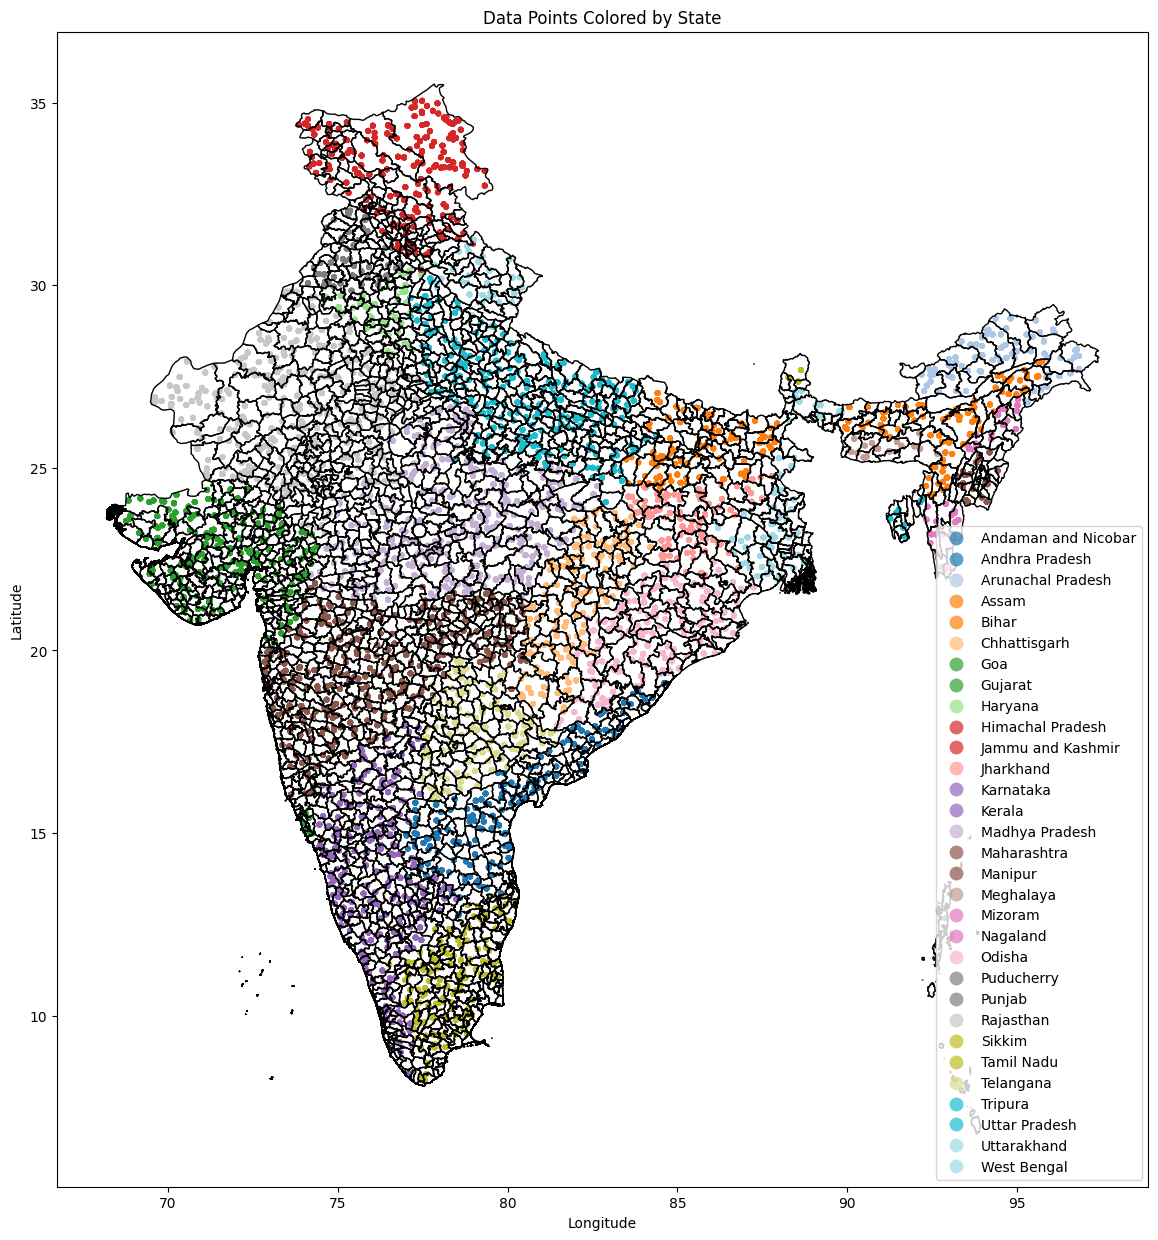

In [33]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# --------------------------
# 1. Load dataset with State/District
# --------------------------
df = pd.read_csv("/kaggle/working/dataset_with_state_district.csv")

# --------------------------
# 2. Convert to GeoDataFrame
# --------------------------
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# --------------------------
# 3. Load India shapefile
# --------------------------
shapefile_path = "/kaggle/input/india-map-state-district-boundaries/India-map/IND_adm3.shp"
gdf_shapes = gpd.read_file(shapefile_path)

# --------------------------
# 4. Plot
# --------------------------
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot India boundaries
gdf_shapes.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

# Plot points, colored by State
gdf_points.plot(
    ax=ax,
    column='State',
    cmap='tab20',      # You can change colormap
    legend=True,
    markersize=10,
    alpha=0.7
)

plt.title("Data Points Colored by State")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
